# Alura - Imersão de Dados - Aula 3

<p>Nessa aula será utilizado o DataSet de imóveis de São Paulo, obtido do Kaggle, e iremos tentar resolver alguns problemas:</p>

<ol>
    <li>Tentar vincular dados do IBGE com dados de imóveis; </li>
    <li>Tratar os outliers e comparar com os resultados; </li>
    <li>Agrupar por mais de uma categoria e realizar as análises. </li>
</ol>

## Declaração de importações

In [1]:
#Importando bibliotecas importantes
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import chardet as cdt #Para o encoding dos dados do IBGE
#sns.set(style = "white")
from colorsys import hls_to_rgb #Para cores!
from scipy import stats #Para tratamento os outliers que irão aparecer.

## Declaração de funções

In [2]:
def retornoDesc(INDEX,LISTA_NULOS,DF_RETORNO,COLUNA):
    """
    A sintaxe dessa função é: retornoDesc(INDEX, LISTA_NULOS, DF_RETORNO, COLUNA)
    Essa função irá retornar o valor "DESCONHECIDO" para colunas que contenham um valor NaN.
    INDEX é uma lista dos índices do dataframe.
    LISTA_NULOS é uma lista TRUE/FALSE contendo informações a respeito da existência ou não de um NaN.
    DF_RETORNO é o dataframe que estaremos fazendo modificações
    COLUNA é a coluna em que estaremos fazendo modificações.
    """
    for i in INDEX:
        if LISTA_NULOS[i]:
            DF_RETORNO[COLUNA].loc[i] = "Desconhecido"
    return DF_RETORNO

def bairros_ruins(DATASET,AGRUPAMENTO,CONTAGEM="Metragem",CASAS=3):
    """
    A sintaxe da função é: bairros_ruins(DATASET, AGRUPAMENTO, CONTAGEM, CASAS=3)
    Essa função irá criar um lista para salvar os bairros que tenham um número menor de casas do que 
    é especificado para a função e irá retornar essa lista. 
    O DATASET será responsável por carregar o dataframe que será analisado. 
    O BAIRRO será responsável pelo agrupamento dos bairros.
    A CONTAGEM será o termo utilizado para que a contagem do número de casas seja feita. 
    Por fim, CASAS é o número de "corte" para algo ser salvo na lista.
    """
    lista_retorno = []
    for i in DATASET.groupby([AGRUPAMENTO]).count()[CONTAGEM].index:
        val = DATASET.groupby([AGRUPAMENTO]).count()[CONTAGEM].loc[i]
        if val <=CASAS:
            lista_retorno.append(i)
    return lista_retorno

def tukeys_method(df, variable):
    """
    Essa função é o método de Tukey para a detecção de Outliers. Ela separa os dados, que seriam vistos em
    um boxplot, em dados dentro de uma certa "zona", eles serão separados em dados que podem ser outliers
    (que fica entre a zona interna e a zona externa) e dados que provavelmente são outliers (que ficam
    localizados após a zona externa)
    Sua sintaxe é: tukeys_method(df,variable)
    Onde "df" é o dataframe.
    "variable" é a variável/coluna que queremos observar a existência de outliers. 
    """
    #Takes two parameters: dataframe & variable of interest as string
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3-q1
    inner_fence = 1.5*iqr
    outer_fence = 3*iqr
    
    #inner fence lower and upper end
    inner_fence_le = q1-inner_fence
    inner_fence_ue = q3+inner_fence
    
    #outer fence lower and upper end
    outer_fence_le = q1-outer_fence
    outer_fence_ue = q3+outer_fence
    
    outliers_prob = []
    outliers_poss = []
    for index, x in enumerate(df[variable]):
        if x <= outer_fence_le or x >= outer_fence_ue:
            outliers_prob.append(index)
    for index, x in enumerate(df[variable]):
        if x <= inner_fence_le or x >= inner_fence_ue:
            outliers_poss.append(index)
    return outliers_prob, outliers_poss

#Uma função para fazer gráficos em barras. Aqui ela apenas faz com que os valores de cada barra sejam 
#postos em cima de sua respectiva barra. Qualquer outra alteração extra no gráfico deve ser feita de
#maneira separada.
def grap_retorno(VAL_X,VAL_Y,ARG_FONTE=20,ARG1_COR=0.2,ARG2_COR=1,RAN1=20,RAN2=30):
    cor = [(hls_to_rgb(i/(4*len(VAL_Y)),ARG1_COR,ARG2_COR)) for i in range(RAN1,RAN2)]
    ax = plt.bar(VAL_X,VAL_Y, color=cor)
    for val in ax:
        alt = val.get_height()
        plt.text(val.get_x() + val.get_width() / 2.0 ,alt,f'{alt: .0f}',ha="center",va="bottom", fontsize=ARG_FONTE)
    return ax 

## Rotina

In [3]:
#Caminho dos dados
path = 'https://gist.githubusercontent.com/tgcsantos/3bdb29eba6ce391e90df2b72205ba891/raw/22fa920e80c9fa209a9fccc8b52d74cc95d1599b/dados_imoveis.csv'

In [4]:
DF_or = pd.read_csv(path) #Leio o arquivo CSV
DF_or

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$ 7.000.000
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$ 3.700.000
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$ 380.000
3,NaN,Jardim Morumbi,São Paulo,310,3,2,4,R$ 685.000
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$ 540.000
...,...,...,...,...,...,...,...,...
10003,Rua Tapuçu,Vila Sofia,São Paulo,95,2,2,2,R$ 665.000
10004,Rua Guararema,Bosque da Saúde,São Paulo,605,8,7,5,R$ 2.300.000
10005,Rua Estero Belaco,Vila da Saúde,São Paulo,205,3,3,6,R$ 1.050.000
10006,"Rua Manuel Onha, , 514",Vila Oratório,São Paulo,185,3,2,2,R$ 2.200\n /Mês


In [5]:
DF_or.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10008 entries, 0 to 10007
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Rua        6574 non-null   object
 1   Bairro     9996 non-null   object
 2   Cidade     10008 non-null  object
 3   Metragem   10008 non-null  int64 
 4   Quartos    10008 non-null  int64 
 5   Banheiros  10008 non-null  int64 
 6   Vagas      10008 non-null  int64 
 7   Valor      10008 non-null  object
dtypes: int64(4), object(4)
memory usage: 625.6+ KB


### Limpeza inicial dos dados:

In [182]:
DF_copia = DF_or.copy()
#Altero o dataframe pra conter tudo existente no split.
#A coluna "Moeda" é puramente o cifrão.
#A coluna "Valor_Bruto" é o valor da casa, esteja ela a venda ou para alugar.
#A coluna "Tipo" envolve se a casa está a venda ou é de aluguel.
DF_copia[["Moeda","Valor_Bruto","Tipo"]] = DF_copia["Valor"].str.split(expand = True) 

#Jogo fora valores não nulos de dentro da tabela, isso permitirá retirar o preço de alugueis!
#Devemos ter em mente que esse método leva em consideração o fato de que os dados de aluguel foram 
#adicionados aos dados, caso tenha sido "13 mil reais por ano" mas sem o "por ano".
DF_copia = DF_copia[DF_copia["Tipo"].isnull()] 

#Jogo fora a tabela de tipo e de moeda, afinal de contas a única coisa que me restou foram as casas
#Que estão a venda e sabemos que a moeda aceita é o Real.
DF_copia.drop(labels=["Valor","Tipo","Moeda"], axis=1, inplace=True)

#Por fim, crio uma separaçãoo dos valores em Valor_Bruto e escrevo eles de forma "inteira", em seguida
#altero o tipo de dado para float64.
DF_copia["Valor_Bruto"] = DF_copia["Valor_Bruto"].str.replace('.',"").astype("float64")

#Agora que mudei o formato do Valor_Bruto, posso tentar retirar os dados de aluguel "restantes" do
#primeiro expurgo feito ali em cima. Aqui, vou colocar como "valor de corte" o preço de 48 mil reais
#pelo simples fato de que na minha pobre cabeça ninguém pagará 4 mil reais por mês de aluguel ou 48 mil
#reais por ano para uma casa que essa pessoa não é dona ou não está comprando.
DF_copia = DF_copia[DF_copia["Valor_Bruto"]>48000.0]

#Dropo o que tiver mais de 10 quartos, que nesse caso vou supor que é uma república e não serão usadas
#na análise.
DF_copia = DF_copia[DF_copia["Quartos"]<10]

#Faço um drop na metragem. Após analisar os dados foi possível observar a existência de imóveis com uma
#metragem maior que 5000.
DF_copia = DF_copia[DF_copia["Metragem"]<5000]

#Obtenho o valor por M2 do dataset.
DF_copia["Valor_M2"] = round(DF_copia["Valor_Bruto"]/DF_copia["Metragem"],2)

#Limpo o nome dos bairros no dataset.
DF_copia["Bairro"].unique()
Dicio_replace = {
    "Jardim Tremembe":"Jardim Tremembé", "Jardim Peri":"Jardim Peri Peri", 
    "Jardim São Paulo(Zona Norte)":"Jardim São Paulo (Zona Norte)",
    "Vila ESão Pauloerança":"Vila São Paulo Herança"
    ""
}
DF_copia.replace(Dicio_replace, inplace=True)

#Por fim, pego todos os bairros entrados como NaN e mudo o seu nome para "Desconhecido"
lista_index = DF_copia.index
lista_nulos_DF_Bai = DF_or["Bairro"].isnull()
DF_copia = retornoDesc(lista_index, lista_nulos_DF_Bai, DF_copia, "Bairro")

#E agora jogo fora TODOS os bairros que contenham menos de CINCO CASAS a venda.
lista = bairros_ruins(DATASET = DF_copia, AGRUPAMENTO = "Bairro", CASAS=5)
DF_copia.set_index("Bairro", inplace=True)
DF_copia.drop(lista, axis=0, inplace=True)
DF_copia.reset_index(inplace=True)

<ipython-input-182-66b7ab6971a7>:19: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  DF_copia["Valor_Bruto"] = DF_copia["Valor_Bruto"].str.replace('.',"").astype("float64")
C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## Primeiro Desafio:

<p>Tentar vincular dados do IBGE com dados de imóveis.</p>

In [183]:
#Caminho dos dados do IBGE
path_IBGE = 'https://gist.githubusercontent.com/tgcsantos/85f8c7b0a2edbc3e27fcad619b37d886/raw/a4954781e6bca9cb804062a3eea0b3b84679daf4/Basico_SP1.csv'

In [184]:
#Leio os dados do IBGE
dados_IBGE = pd.read_csv(path_IBGE
                         ,encoding = 'UTF-8', sep = ';', decimal=',')
dados_IBGE.drop("Unnamed: 33", axis=1, inplace=True)

In [185]:
print(list(dados_IBGE))

['Cod_setor', 'Cod_Grandes Regi�es', 'Nome_Grande_Regiao', 'Cod_UF', 'Nome_da_UF ', 'Cod_meso', 'Nome_da_meso', 'Cod_micro', 'Nome_da_micro', 'Cod_RM', 'Nome_da_RM', 'Cod_municipio', 'Nome_do_municipio', 'Cod_distrito', 'Nome_do_distrito', 'Cod_subdistrito', 'Nome_do_subdistrito', 'Cod_bairro', 'Nome_do_bairro', 'Situacao_setor', 'Tipo_setor', 'V001', 'V002', 'V003', 'V004', 'V005', 'V006', 'V007', 'V008', 'V009', 'V010', 'V011', 'V012']


In [186]:
#Excluo as colunas "inúteis" dos dados do IBGE.
dados_IBGE_cop = dados_IBGE.copy()
dados_IBGE_cop.replace('�','ã', regex=True, inplace=True)
dados_IBGE_cop.drop(["Cod_UF","Nome_Grande_Regiao","Cod_Grandes Regi�es","Cod_meso"
                    ,"Nome_da_meso","Cod_micro","Nome_da_micro","Nome_da_RM","Cod_RM"
                    ,"Cod_municipio","Cod_bairro","Nome_do_bairro","Nome_do_subdistrito"]
                    , axis=1, inplace=True)
dados_IBGE_cop

,Cod_setor,Nome_da_UF,Nome_do_municipio,Cod_distrito,Nome_do_distrito,Cod_subdistrito,Situacao_setor,Tipo_setor,V001,V002,V003,V004,V005,V006,V007,V008,V009,V010,V011,V012
0,355030801000001,São Paulo,SãO PAULO,355030801,ãGUA RASA,35503080100,1,0,266.0,800.0,3.01,2.32,2091.32,8532451.78,2164.55,8673276.78,1227.41,4285771.99,1713.75,5152087.86
1,355030801000002,São Paulo,SãO PAULO,355030801,ãGUA RASA,35503080100,1,0,306.0,913.0,2.98,2.09,1650.09,3983441.31,1717.44,4030519.99,1045.78,2572133.32,1468.08,2991546.94
2,355030801000003,São Paulo,SãO PAULO,355030801,ãGUA RASA,35503080100,1,0,189.0,625.0,3.31,3.08,1280.43,5474593.06,2349.53,7553913.02,902.97,2735492.52,1786.79,3837674.74
3,355030801000004,São Paulo,SãO PAULO,355030801,ãGUA RASA,35503080100,1,0,181.0,572.0,3.16,2.26,1119.59,3572955.10,1859.13,4567289.50,869.09,2122409.02,1567.41,2735383.24
4,355030801000005,São Paulo,SãO PAULO,355030801,ãGUA RASA,35503080100,1,0,240.0,754.0,3.14,2.35,1416.90,2240207.58,1581.66,2240109.39,917.71,1570047.75,1356.35,1725877.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18358,355030896000243,São Paulo,SãO PAULO,355030896,LAJEADO,35503089600,1,1,96.0,336.0,3.50,2.61,772.09,168751.10,814.52,143188.21,467.46,191332.48,699.95,123399.08
18359,355030896000244,São Paulo,SãO PAULO,355030896,LAJEADO,35503089600,1,1,54.0,209.0,3.87,2.49,692.50,239941.27,812.93,182516.20,439.33,194034.99,702.10,124952.38
18360,355030896000245,São Paulo,SãO PAULO,355030896,LAJEADO,35503089600,1,1,87.0,339.0,3.90,2.54,630.06,329705.22,843.31,260395.90,347.60,228162.66,767.50,181129.99
18361,355030896000246,São Paulo,SãO PAULO,355030896,LAJEADO,35503089600,1,0,38.0,163.0,4.29,4.21,597.37,349101.00,908.00,244391.67,397.76,436942.16,854.20,550319.43


In [187]:
dados_IBGE_cop["Nome_do_distrito"].unique()
dicionario_distrito_IBGE = {
    "ãGUA RASA":"ÁGUA RASA", "BELãM":"BELÉM", "BRãS":"BRÁS", "BRASILãNDIA":"BRASILÁNDIA",
    "BUTANTã":"BUTANTÃ","CAPãO REDONDO":"CAPÃO REDONDO","CARRãO":"CARRÃO","CONSOLAããO":"CONSOLAÇÃO",
    "FREGUESIA DO ã":"FREGUESIA DO Ó","GRAJAã":"GRAJAU","JAãANã":"JAÇANÃ","JAGUARã":"JAGUARÉ",
    "JARAGUã":"JARAGUÁ", "JARDIM ãNGELA":"JARDIM ÂNGELA","JARDIM SãO LUãS":"JARDIM SÃO LUÍS",
    "JOSã BONIFãCIO":"JOSÉ BONIFÁCIO", "LIMãO":"LIMÃO", "REPãBLICA":"REPÚBLICA", "SACOMã":"SACOMÃ",
    "SANTA CECãLIA":"SANTA CECÍLIA", "SãO LUCAS":"SÃO LUCAS", "SãO MATEUS":"SÃO MATEUS", 
    "SãO MIGUEL":"SÃO MIGUEL", "SãO RAFAEL":"SÃO RAFAEL", "SAãDE":"SAÚDE", "Sã":"SÉ","TATUAPã":"TATUAPÉ",
    "TREMEMBã":"TREMEMBÉ", "VILA CURUãã":"VILA CURUÇÁ", "VILA JACUã":"VILA JACUÍ", "VILA SãNIA":"VILA SÔNIA",
    "SãO DOMINGOS":"SÃO DOMINGOS"
}
dados_IBGE_cop["Nome_do_distrito"].replace(dicionario_distrito_IBGE, inplace = True)
dados_IBGE_cop["Nome_do_distrito"].unique()

array(['ÁGUA RASA', 'ALTO DE PINHEIROS', 'ANHANGUERA', 'ARICANDUVA',
       'ARTUR ALVIM', 'BARRA FUNDA', 'BELA VISTA', 'BELÉM', 'BOM RETIRO',
       'BRÁS', 'BRASILÁNDIA', 'BUTANTÃ', 'CACHOEIRINHA', 'CAMBUCI',
       'CAMPO BELO', 'CAMPO GRANDE', 'CAMPO LIMPO', 'CANGAIBA',
       'CAPÃO REDONDO', 'CARRÃO', 'CASA VERDE', 'CIDADE ADEMAR',
       'CIDADE DUTRA', 'CIDADE LIDER', 'CIDADE TIRADENTES', 'CONSOLAÇÃO',
       'CURSINO', 'ERMELINO MATARAZZO', 'FREGUESIA DO Ó', 'GRAJAU',
       'GUAIANASES', 'MOEMA', 'IGUATEMI', 'IPIRANGA', 'ITAIM BIBI',
       'ITAIM PAULISTA', 'ITAQUERA', 'JABAQUARA', 'JAÇANÃ', 'JAGUARA',
       'JAGUARÉ', 'JARAGUÁ', 'JARDIM ÂNGELA', 'JARDIM HELENA',
       'JARDIM PAULISTA', 'JARDIM SÃO LUÍS', 'JOSÉ BONIFÁCIO', 'LAPA',
       'LIBERDADE', 'LIMÃO', 'MANDAQUI', 'MARSILAC', 'MOOCA', 'MORUMBI',
       'PARELHEIROS', 'PARI', 'PARQUE DO CARMO', 'PEDREIRA', 'PENHA',
       'PERDIZES', 'PERUS', 'PINHEIROS', 'PIRITUBA', 'PONTE RASA',
       'RAPOSO TAVARES', 'REPÚBLICA

## Segundo Desafio:

<p>Localizar e tratar os outliers presentes no dataset.</p>

In [419]:
#Aqui irei começar a dropar os outliers.
DF_copia2 = DF_copia.copy()

#Utilizo o método de Tukeys para encontrar outliers nas variáveis.
#Aqui estou buscando preços de casas que são outliers. 
prov_brut, poss_brut = tukeys_method(DF_copia,"Valor_Bruto")
drop_out_brut = np.unique(poss_brut+prov_brut)

#Faço um drop nos prováveis outliers no valor bruto.
DF_copia2.drop(drop_out_brut, axis=0, inplace=True)
DF_copia2.drop(DF_copia2[DF_copia2["Bairro"]=="Desconhecido"].index, axis=0, inplace=True)

In [431]:
#Aqui irei começar a dropar os outliers.
DF_copia2 = DF_copia.copy()
z_scores = stats.zscore(DF_copia2)

abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
New_DF = DF_copia2[filtered_entries]

KeyError: ('Valor_Bruto', 'Metragem')

[]

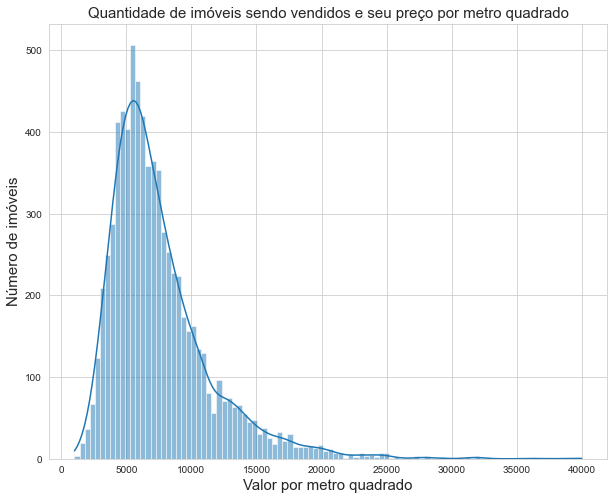

In [420]:
fonte = {'size':15}
sns.set_style("whitegrid")
plt.figure(figsize=(10,8))
sns.histplot(data = DF_copia2, x="Valor_M2", bins=100, kde=True)
plt.xlabel("Valor por metro quadrado", fontdict = fonte)
plt.ylabel("Número de imóveis", fontdict = fonte)
plt.title("Quantidade de imóveis sendo vendidos e seu preço por metro quadrado", fontdict = fonte)
plt.plot()

In [421]:
antes_outliers = DF_copia["Valor_Bruto"].sum()/DF_copia["Metragem"].sum()
apos_outliers = DF_copia2["Valor_Bruto"].sum()/DF_copia2["Metragem"].sum()
print("Antes do tratamento dos dados em busca de outliers o preço do metro quadrado em São Paulo é:",
     antes_outliers)
print("Após o tratamento dos dados o preço do metro quadrado em São Paulo é:",
      apos_outliers)
print("Portanto temos uma diferença de:", antes_outliers-apos_outliers)

Antes do tratamento dos dados em busca de outliers o preço do metro quadrado em São Paulo é: 9159.040148717548
Após o tratamento dos dados o preço do metro quadrado em São Paulo é: 7388.084012636274
Portanto temos uma diferença de: 1770.956136081274


<p>De acordo com o site <a href=https://www.proprietariodireto.com.br/preco-m2-sao-paulo>Proprietário Direto</a> o valor do metro quadrado em São Paulo gira em torno de RS7500. Em nossos dados temos uma diferença pequena, de mais ou menos RS120.</p>

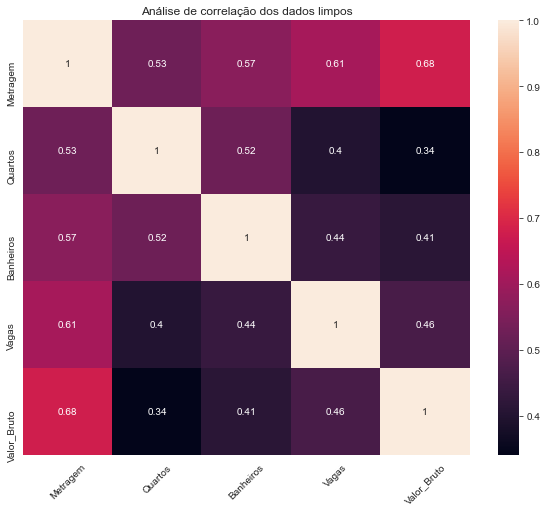

In [447]:
#Análise de correlação das variáveis do dataset após a filtragem
plt.figure(figsize=(10,8))
ax = sns.heatmap(DF_copia2.drop(["Valor_M2"], axis=1).corr(), annot= True)
plt.title("Análise de correlação dos dados limpos")
ax.tick_params(axis = 'x', rotation = 45)

In [422]:
DF_copia2_agrup_bairro_sum = DF_copia2.groupby(["Bairro"]).sum()
DF_copia2_agrup_bairro_sum["Valor_M2_PB"] = DF_copia2_agrup_bairro_sum["Valor_Bruto"]/DF_copia2_agrup_bairro_sum["Metragem"]
DF_copia2_agrup_bairro_sum.sort_values(by="Valor_M2_PB", inplace=True, ascending = False)
DF_copia2_agrup_bairro_sum.reset_index(inplace=True)
DF_copia2_agrup_bairro_sum.head(10)

,Bairro,Metragem,Quartos,Banheiros,Vagas,Valor_Bruto,Valor_M2,Valor_M2_PB
0,Vila Nova Conceição,16898,231,236,228,282775000.0,1306456.30,16734.228903
1,Jardim Europa,28811,289,319,264,446096000.0,1452114.97,15483.530596
2,Jardim América,10525,105,105,152,155250000.0,444485.45,14750.593824
3,Jardim Paulistano,33239,377,385,379,456730001.0,1531390.45,13740.786456
4,Jardim Luzitânia,21453,176,242,206,292210000.0,722233.11,13620.938796
5,Itaim Bibi,3719,58,62,45,49865000.0,327414.09,13408.174240
6,Chácara Flora,632,4,5,6,8000000.0,12658.23,12658.227848
7,Jardim Paulista,64557,646,713,693,816664000.0,2390002.22,12650.278049
8,Brooklin Novo,2298,26,32,37,28700000.0,98745.21,12489.120975
9,Vila Olímpia,12244,187,206,141,150005000.0,782990.48,12251.306762


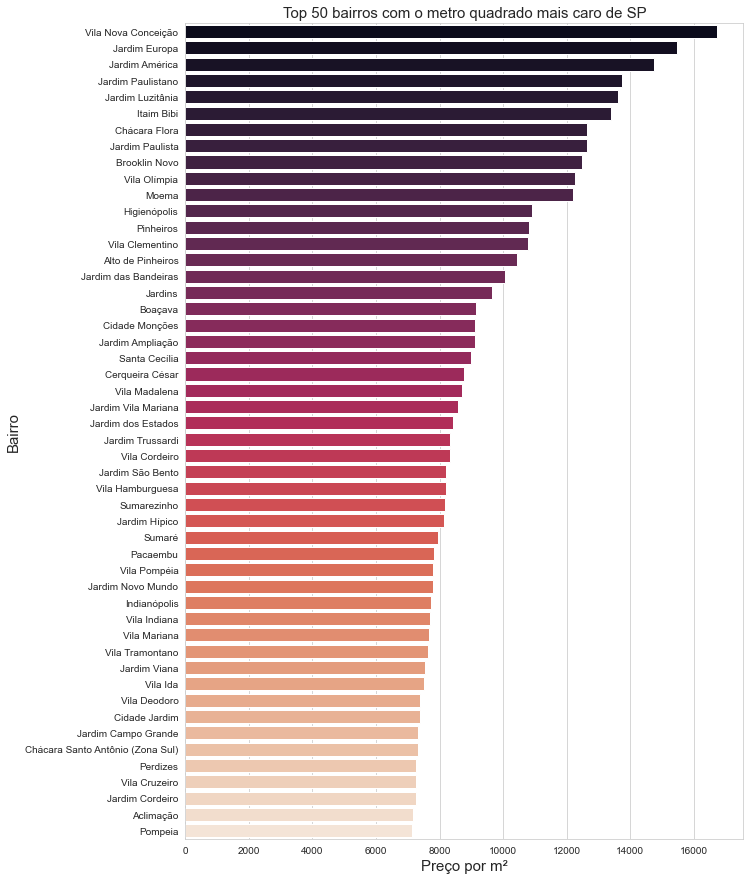

In [423]:
fonte = {'size':15}
plt.figure(figsize=(10,15))
sns.set_style("whitegrid")
sns.barplot(data = DF_copia2_agrup_bairro_sum.head(50),
            x="Valor_M2_PB", y="Bairro", palette="rocket")
plt.xlabel("Preço por m²",fontdict=fonte)
plt.ylabel("Bairro",fontdict=fonte)
plt.title("Top 50 bairros com o metro quadrado mais caro de SP",fontdict=fonte)
plt.show()

In [427]:
DF_copia3=DF_copia2.copy()
DF_copia3.set_index("Bairro", inplace=True)
DF_copia3["Valor_Bruto_PMILHAO"] = DF_copia3["Valor_Bruto"]/1000000

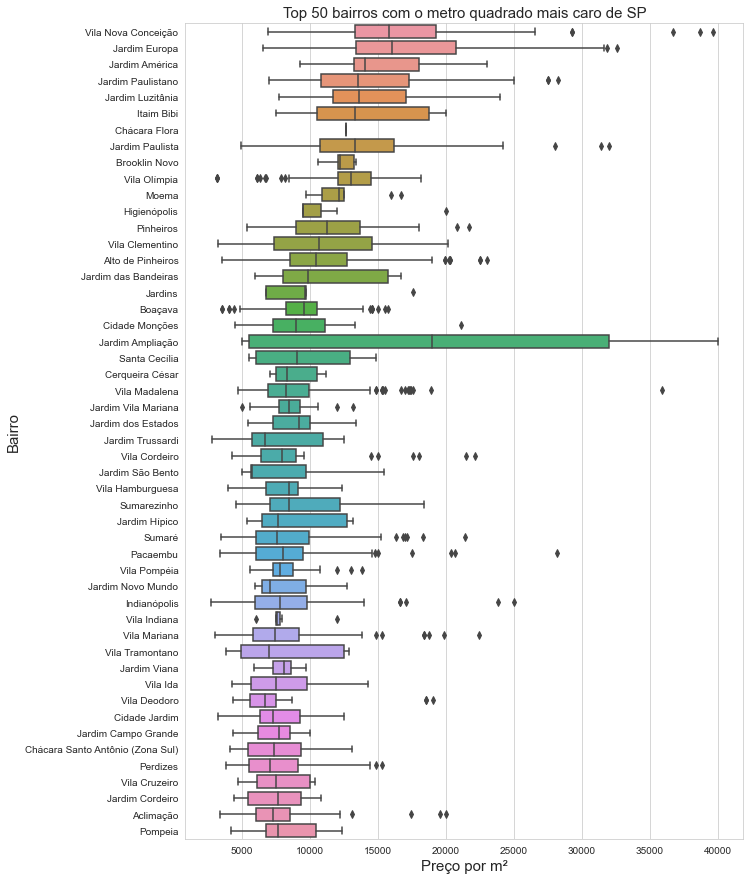

In [425]:
listaBairros = DF_copia2_agrup_bairro_sum.set_index("Bairro").head(50).index
fonte = {'size':15}
plt.figure(figsize=(10,15))
sns.boxplot(data = DF_copia3.loc[listaBairros],
           x="Valor_M2", y=DF_copia3.loc[listaBairros].index)
plt.xlabel("Preço por m²",fontdict=fonte)
plt.ylabel("Bairro",fontdict=fonte)
plt.title("Top 50 bairros com o metro quadrado mais caro de SP",fontdict=fonte)
plt.show()

<p>Podemos notar que mesmo após uma primeira tentativa da eliminação dos outliers do dataset alguns ainda restaram. Uma possível saida seria tentar buscar os outliers por bairro e eliminá-los. Contudo, nesse caso teríamos que ter "fé" na ideia de que os dados a respeito do bairro não sejam formado por uma maioria de outliers. Devido aos poucos dados por bairro em cada conjunto desse dataset eu não acredito que essa seja a melhor saída.</p>

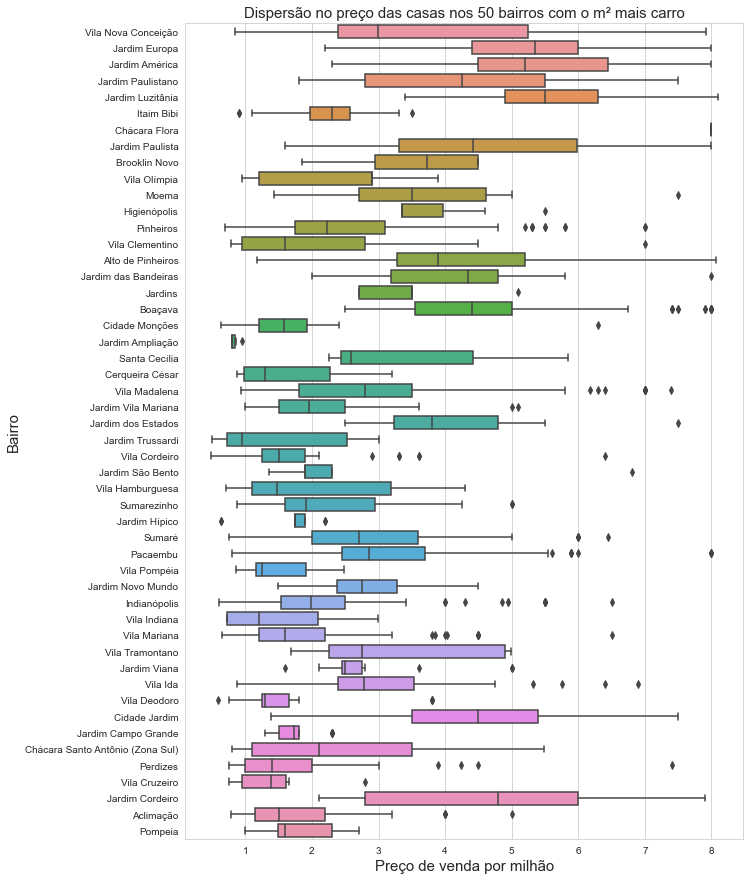

In [426]:
listaBairros = DF_copia2_agrup_bairro_sum.set_index("Bairro").head(50).index
fonte = {'size':15}
plt.figure(figsize=(10,15))
sns.boxplot(data = DF_copia3.loc[listaBairros],
           x="Valor_Bruto_PMILHAO", y=DF_copia3.loc[listaBairros].index)
plt.xlabel("Preço de venda por milhão",fontdict=fonte)
plt.ylabel("Bairro",fontdict=fonte)
plt.title("Dispersão no preço das casas nos 50 bairros com o m² mais carro",fontdict=fonte)
plt.show()

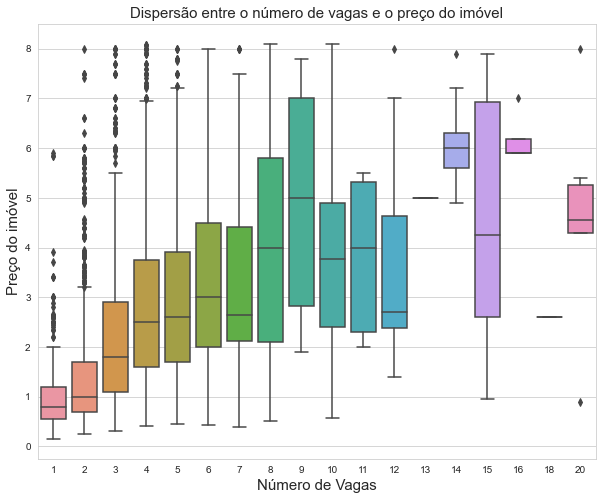

In [441]:
listaBairros = DF_copia2_agrup_bairro_sum.set_index("Bairro").head(50).index
fonte = {'size':15}
plt.figure(figsize=(10,8))
sns.boxplot(data = DF_copia3.query("Vagas < 21"),
           x="Vagas", y="Valor_Bruto_PMILHAO")
plt.xlabel("Número de Vagas",fontdict=fonte)
plt.ylabel("Preço do imóvel",fontdict=fonte)
plt.title("Dispersão entre o número de vagas e o preço do imóvel",fontdict=fonte)
plt.show()